# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

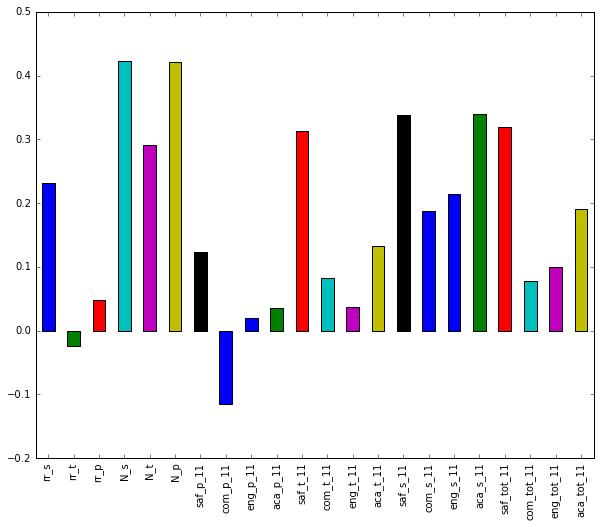

In [30]:
plt.figure(figsize=(10,8))
combined.corr()["sat_score"][survey_fields].plot.bar()
plt.show()

There is a high correlation between N_s, N_t, N_p and sat_score. These columns are directly correlated with total_enrolment, so it make sense for the high correlation to exist between these variables and sat_score.

saf_t_11 and saf_s_11 are also closely correlated with sat_score, as these columns represent how teachers and students percieved safety. Since, it would be harder to teach with efficiency in an unsafe environment, higher sat_score exist in safer environment.

There is also a correlation between rr_s (response rate of students) and sat_score, as this suggests that students who did academically well are more like to complete the survey.

How the student perceives academic standard is indicated by aca_s_11, which is also highly correlated with sat_Score.

# Exploring safety scores

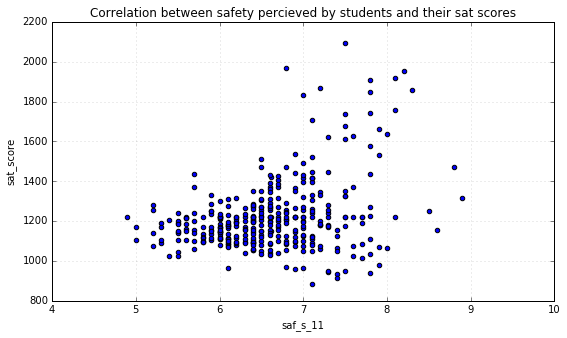

In [33]:
plt.figure(figsize=(9,5))
plt.scatter(combined["saf_s_11"], combined["sat_score"])
plt.grid(alpha=0.3)
plt.xlabel("saf_s_11")
plt.ylabel("sat_score")
plt.title("Correlation between safety percieved by students and their sat scores")
plt.show()

There seems to be a correlation between 'saf_s_11' and 'sat_score', but not that strong. There are some schools with high safety score but low sat scores (lower than the ones with lower safety score). However, no school with a very low safety score ( ~ 6.5 ) has a sat score above 1500.

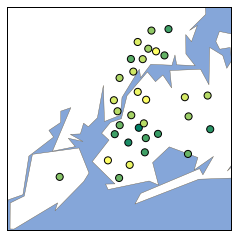

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

# Exploring racial differences in SAT scores

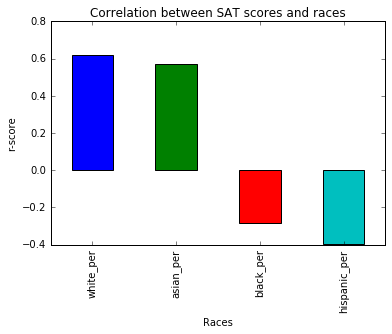

In [39]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()["sat_score"][races].plot.bar()
plt.xlabel("Races")
plt.ylabel("r-score")
plt.title("Correlation between SAT scores and races")
plt.show()

It appears that schools with a higher percentage of white or asian students are more likely to score better in SAT score than schools with higher percentage of black or hispanic students. This could be a result of lack of funding in certain areas and regions.

### Schools with high percentage of hispanic students

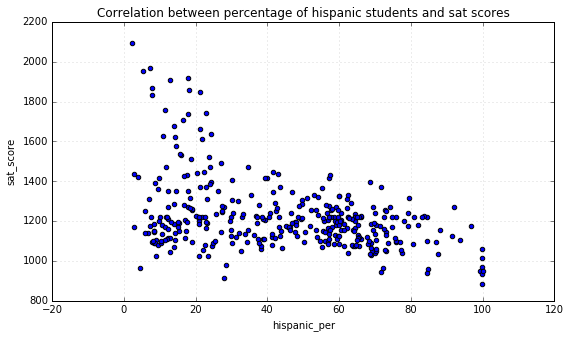

In [40]:
plt.figure(figsize=(9,5))
plt.scatter(combined["hispanic_per"], combined["sat_score"])
plt.grid(alpha=0.3)
plt.xlabel("hispanic_per")
plt.ylabel("sat_score")
plt.title("Correlation between percentage of hispanic students and sat scores")
plt.show()

In [41]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [42]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Exploring gender differences in SAT scores

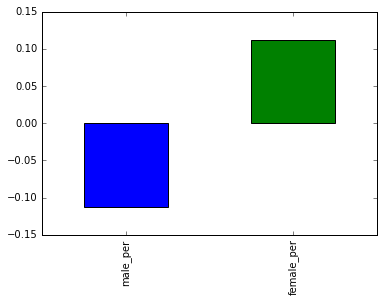

In [43]:
genders = ['male_per', 'female_per']
combined.corr()["sat_score"][genders].plot.bar()

Schools with higher percentage of female students seem to be positively correlated with SAT scores, while higher percentage of male students negatively correlae with SAT scores. Neither of correlations are strong.

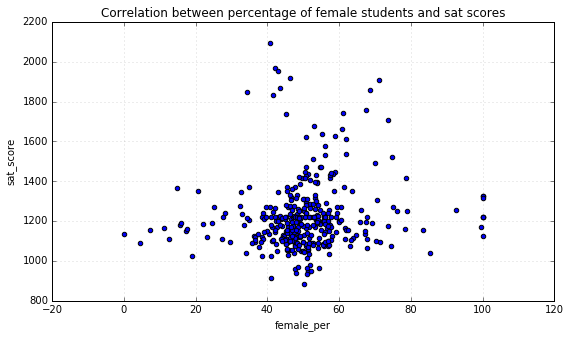

In [44]:
plt.figure(figsize=(9,5))
plt.scatter(combined["female_per"], combined["sat_score"])
plt.grid(alpha=0.3)
plt.xlabel("female_per")
plt.ylabel("sat_score")
plt.title("Correlation between percentage of female students and sat scores")
plt.show()

It does not seem like there is any real correlation between percentage of female students and SAT scores.

In [46]:
print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

# Exploring AP test scores and SAT scores

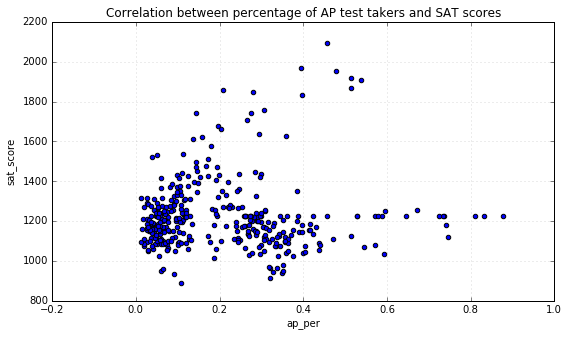

In [49]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

plt.figure(figsize=(9,5))
plt.scatter(combined["ap_per"], combined["sat_score"])
plt.grid(alpha=0.3)
plt.xlabel("ap_per")
plt.ylabel("sat_score")
plt.title("Correlation between percentage of AP test takers and SAT scores")
plt.show()

There appears to be a very weak correlation between percentage of students who took AP test and SAT scores.